# Adding lysine export reaction
Author: 
`Haroun Bensaadi`

In [6]:
%%capture
%run gene_annotation.ipynb

from IPython.display import display, clear_output
from cobra.io import read_sbml_model

model = read_sbml_model('Files/iCGB21FR.xml')

In [7]:
printText("\nAll reactions", Fore.BLACK, Style.NORMAL)
shown_reactions = []
for reaction in model.reactions:
    for lysine_id in [metabolite.id for metabolite in model.metabolites.query("lys")]:
        if lysine_id in reaction.reaction:
            if reaction.id not in ["Growth"] and reaction.id not in shown_reactions:
                shown_reactions.append(reaction.id)
                printText(f"    { reaction.id}", Fore.BLACK, Style.BRIGHT)
                print(f"    {reaction.reaction}")
                #print(f"{reaction.lower_bound, reaction.upper_bound}")

printText("\nMetabolism reactions (cytosol)", Fore.YELLOW)
shown_reactions = []
reactions_to_show = ["DAPDC"]

for reaction in model.reactions:
    for lysine_id in [metabolite.id for metabolite in model.metabolites.query("lys")]:
        if lysine_id in reaction.reaction:
            if reaction.id not in ["Growth"] and reaction.id not in shown_reactions and reaction.id in reactions_to_show:
                shown_reactions.append(reaction.id)
                printText(f"    { reaction.id}", Fore.YELLOW)
                print(f"    {reaction.reaction}")
                #print(f"{reaction.lower_bound, reaction.upper_bound}")

printText("\nImport reactions (extra cellular -> cytosol)", Fore.GREEN)
shown_reactions = []
reactions_to_show = ["LYSabc"]

for reaction in model.reactions:
    for lysine_id in [metabolite.id for metabolite in model.metabolites.query("lys")]:
        if lysine_id in reaction.reaction:
            if reaction.id not in ["Growth"] and reaction.id not in shown_reactions and reaction.id in reactions_to_show:
                shown_reactions.append(reaction.id)
                printText(f"    { reaction.id}", Fore.GREEN)
                print(f"    {reaction.reaction}")
                #print(f"{reaction.lower_bound, reaction.upper_bound}")

printText("\nImport reactions (extra cellular -> permiplasm)", Fore.GREEN)
print(f"    None")
print(f"    None")


printText("\nImport reactions (periplasm -> cytosol)", Fore.GREEN)
shown_reactions = []
reactions_to_show = ["LYSabcpp"]

for reaction in model.reactions:
    for lysine_id in [metabolite.id for metabolite in model.metabolites.query("lys")]:
        if lysine_id in reaction.reaction:
            if reaction.id not in ["Growth"] and reaction.id not in shown_reactions and reaction.id in reactions_to_show:
                shown_reactions.append(reaction.id)
                printText(f"    { reaction.id}", Fore.GREEN)
                print(f"    {reaction.reaction}")
                #print(f"{reaction.lower_bound, reaction.upper_bound}")
                

printText("\nExport reactions (cytosol -> extra cellular)", Fore.BLUE)
print(f"    None")
print(f"    None")

printText("\nExport reactions (periplasm -> extra cellular)", Fore.BLUE)
print(f"    None")
print(f"    None")

printText("\nExport reactions (cytosol -> periplasm)", Fore.BLUE)
shown_reactions = []
reactions_to_show = ["LYSt3pp"]

for reaction in model.reactions:
    for lysine_id in [metabolite.id for metabolite in model.metabolites.query("lys")]:
        if lysine_id in reaction.reaction:
            if reaction.id not in ["Growth"] and reaction.id not in shown_reactions and reaction.id in reactions_to_show:
                shown_reactions.append(reaction.id)
                printText(f"    { reaction.id}", Fore.BLUE)
                print(f"    {reaction.reaction}")
                #print(f"{reaction.lower_bound, reaction.upper_bound}")


All reactions
    DAPDC
    26dap__M_c + h_c --> co2_c + lys__L_c
    LYSabc
    atp_c + h2o_c + lys__L_e --> adp_c + h_c + lys__L_c + pi_c
    LYSabcpp
    atp_c + h2o_c + lys__L_p --> adp_c + h_c + lys__L_c + pi_c
    LYSt3pp
    h_p + lys__L_c --> h_c + lys__L_p
    EX_lys__L_e
    lys__L_e --> 

Metabolism reactions (cytosol)
    DAPDC
    26dap__M_c + h_c --> co2_c + lys__L_c

Import reactions (extra cellular -> cytosol)
    LYSabc
    atp_c + h2o_c + lys__L_e --> adp_c + h_c + lys__L_c + pi_c

Import reactions (extra cellular -> permiplasm)
    None
    None

Import reactions (periplasm -> cytosol)
    LYSabcpp
    atp_c + h2o_c + lys__L_p --> adp_c + h_c + lys__L_c + pi_c

Export reactions (cytosol -> extra cellular)
    None
    None

Export reactions (periplasm -> extra cellular)
    None
    None

Export reactions (cytosol -> periplasm)
    LYSt3pp
    h_p + lys__L_c --> h_c + lys__L_p


As it can be see from the previous reactions involving lysine, **the model lacks export reactions** of lysine: 
- from **cytosol -> extra cellular space**

OR

- from **periplasm -> extra cellular space**

## Checking literature

(Jie et al. 2023) https://doi.org/10.1016/j.biortech.2023.129701

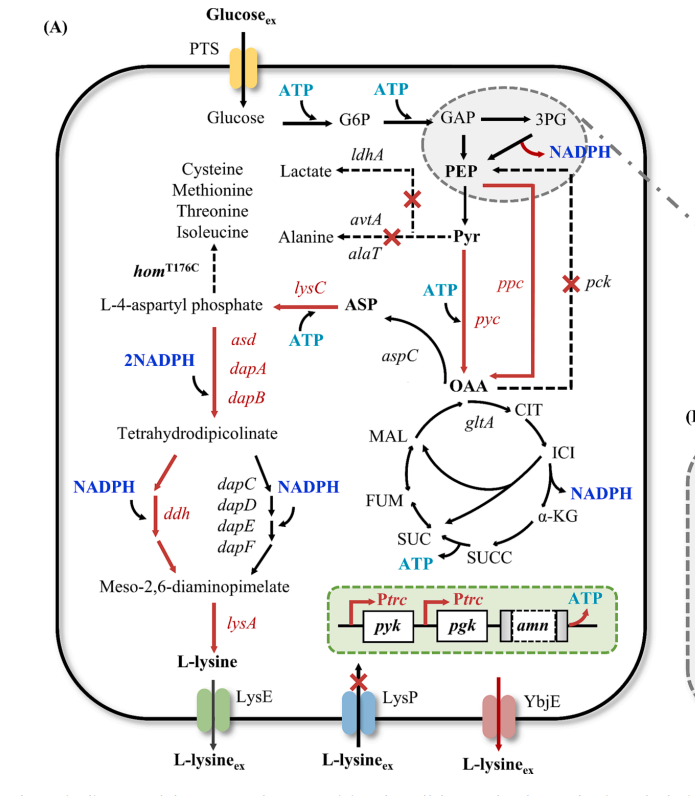




A gene [**ybjE**](https://www.genome.jp/entry/ecs:ECs_0960)  was cited in the paper but it was hard to find any source speaking about the mechanism of its action, and if it is an active or passive transporter

## The solution: 
**Downloading all the models available in BiGG database and searching for all reactions in nature that involve lysine export in order to get a valuable inspiration about the stochiometry of this reaction and its energy consumption**

### Getting all available models from BIGG database

In [8]:
from cobra.io.json import model_from_dict, model_to_dict
import requests
import os


def getAvailableModels():
    response = requests.get('http://bigg.ucsd.edu/api/v2/models')
    model_ids = {}

    if response.status_code == 200:

        models = response.json()['results']

        for model in models:
            bigg_id = model['bigg_id']
            organism = model['organism']
            
            model_ids[bigg_id] = organism
            
        return model_ids

    else:
        print(f"Error: {response.status_code}")
    

def downloadModel(model_id):
    response = requests.get(f'http://bigg.ucsd.edu/api/v2/models/{model_id}/download')
    
    if response.status_code == 200:
        print(f"{model_id} downloaded!")
        model_data = response.json()
        return model_data
    else:
        print(f"Error: {response.status_code}")

def saveBiGGModels(models):
    output_file_path = "Files/BiGG_models.json"
    try:
        with open(output_file_path, 'w') as json_file:
            json.dump(models, json_file)
        print(f"BiGG models saved to {output_file_path}")

    except Exception as e:
        print(f"Error saving BiGG models: {e}")

def loadBiGGModels():
    input_file_path = "Files/BiGG_models.json"
    try:
        with open(input_file_path, 'r') as json_file:
            BiGG_models = json.load(json_file)
        print(f"BiGG models loaded from '{input_file_path}'")
        return BiGG_models
    
    except Exception as e:
        print(f"Error loading BiGG models: {e}")
        return []

In [9]:
available_models = getAvailableModels()

BiGG_models = {}

if not os.path.exists("Files/BiGG_models.json"):
    for model_id in available_models:
        model_json = downloadModel(model_id)
        BiGG_models[model_id] = model_json

    saveBiGGModels(BiGG_models)
    
BiGG_models = loadBiGGModels()

printText(f"\nNumber of BiGG models: {len(BiGG_models)}\n", Fore.BLACK)

for model_id, organism in list(available_models.items()):
    printText(f"{model_id} -> {organism}", Fore.BLACK, Style.DIM)

BiGG models loaded from 'Files/BiGG_models.json'

Number of BiGG models: 108

e_coli_core -> Escherichia coli str. K-12 substr. MG1655
iAB_RBC_283 -> Homo sapiens
iAF1260 -> Escherichia coli str. K-12 substr. MG1655
iAF1260b -> Escherichia coli str. K-12 substr. MG1655
iAF692 -> Methanosarcina barkeri str. Fusaro
iAF987 -> Geobacter metallireducens GS-15
iAM_Pb448 -> Plasmodium berghei
iAM_Pc455 -> Plasmodium cynomolgi strain B
iAM_Pf480 -> Plasmodium falciparum 3D7
iAM_Pk459 -> Plasmodium knowlesi strain H
iAM_Pv461 -> Plasmodium vivax Sal-1
iAPECO1_1312 -> Escherichia coli APEC O1
iAT_PLT_636 -> Homo sapiens
iB21_1397 -> Escherichia coli BL21(DE3)
iBWG_1329 -> Escherichia coli BW2952
ic_1306 -> Escherichia coli CFT073
iCHOv1 -> Cricetulus griseus
iCHOv1_DG44 -> Cricetulus griseus
iCN718 -> Acinetobacter baumannii AYE
iCN900 -> Clostridioides difficile 630
iE2348C_1286 -> Escherichia coli O127:H6 str. E2348/69
iEC042_1314 -> Escherichia coli 042
iEC1344_C -> Escherichia coli C
iEC1349

### Searching through all the BiGG models for lysine export reactions

The reaction of exporting lysine can be identfied as follow:

Either:

**lys__L_c**  ->  **lys__L_e** 

OR  

**lys__L_p**  ->  **lys__L_e**

### Starting with E. coli models only

In [10]:
print_results = ""
N = len(list(BiGG_models.items()))
i = 0

lysine_export_reactions_ecoli = []

for model_id, model_data in list(BiGG_models.items()):
    i+=1

    if "Escherichia coli" in available_models[model_id]:    
        model = model_from_dict(model_data)
        for reaction in model.reactions:        
            for reactant_id in [reactant.id for reactant in reaction.reactants]:
                if "lys__L_c" in reactant_id and len(reaction.reactants) < 15:
                    for product_id in [product.id for product in reaction.products]:
                        if "lys__L_e" in product_id:
                            lysine_export_reactions_ecoli.append(reaction)
                            print_results += f"\n\n{model} [{available_models[model_id]}]:\n    {reaction}"

                if "lys__L_p" in reactant_id and len(reaction.reactants) < 15:
                    for product_id in [product.id for product in reaction.products]:
                        if "lys__L_e" in product_id:
                            lysine_export_reactions_ecoli.append(reaction)
                            print_results += f"\n\n{model} [{available_models[model_id]}]:\n    {reaction}"

    progress_text = f"Progress: {i}/{N}"
    clear_output(wait=True)
    display(progress_text)
    
clear_output()
print("Search completed!")

print(print_results)

if len(lysine_export_reactions_ecoli) == 0:
    print("No results were found in E. coli models")

Search completed!

No results were found in E. coli models


**Given no results were found for E. coli models**

#### ==>  searching in the rest of the models of other organisms

In [11]:
print_results = ""
N = len(list(BiGG_models.items()))
i = 0

lysine_export_reactions = []

for model_id, model_data in list(BiGG_models.items()):
    i+=1

    if "Escherichia coli" not in available_models[model_id]:    
        model = model_from_dict(model_data)
        for reaction in model.reactions:        
            for reactant_id in [reactant.id for reactant in reaction.reactants]:
                if "lys__L_c" in reactant_id and len(reaction.reactants) < 15:
                    for product_id in [product.id for product in reaction.products]:
                        if "lys__L_e" in product_id:
                            lysine_export_reactions.append(reaction)
                            print_results += f"\n\n{model} [{available_models[model_id]}]:\n    {reaction}"

                if "lys__L_p" in reactant_id and len(reaction.reactants) < 15:
                    for product_id in [product.id for product in reaction.products]:
                        if "lys__L_e" in product_id:
                            lysine_export_reactions.append(reaction)
                            print_results += f"\n\n{model} [{available_models[model_id]}]:\n    {reaction}"

    progress_text = f"Progress: {i}/{N}"
    clear_output(wait=True)
    display(progress_text)
    
clear_output()
print("Search completed!")

print(print_results)

Search completed!


iAF692 [Methanosarcina barkeri str. Fusaro]:
    LYSt3r: h_e + lys__L_c <=> h_c + lys__L_e

iAM_Pb448 [Plasmodium berghei]:
    ARGLYSex: arg__L_e + lys__L_c <-- arg__L_c + lys__L_e

iAM_Pc455 [Plasmodium cynomolgi strain B]:
    ARGLYSex: arg__L_e + lys__L_c <-- arg__L_c + lys__L_e

iAM_Pf480 [Plasmodium falciparum 3D7]:
    ARGLYSex: arg__L_e + lys__L_c <-- arg__L_c + lys__L_e

iAM_Pk459 [Plasmodium knowlesi strain H]:
    ARGLYSex: arg__L_e + lys__L_c <-- arg__L_c + lys__L_e

iAM_Pv461 [Plasmodium vivax Sal-1]:
    ARGLYSex: arg__L_e + lys__L_c <-- arg__L_c + lys__L_e

iCHOv1 [Cricetulus griseus]:
    ARGLYSex: arg__L_e + lys__L_c --> arg__L_c + lys__L_e

iCHOv1 [Cricetulus griseus]:
    SERLYSNaex: lys__L_c + na1_e + ser__L_e --> lys__L_e + na1_c + ser__L_c

iCHOv1 [Cricetulus griseus]:
    r1912: gly_e + lys__L_c + na1_e --> gly_c + lys__L_e + na1_c

iCHOv1 [Cricetulus griseus]:
    r1917: ala__L_e + lys__L_c + na1_e --> ala__L_c + lys__L_e + na1_c

iCHOv1 [Cri

**After doing the search, the reactions involving the export of lysine can be summarized as follow:** 

In [12]:
from IPython.display import HTML

no_duplicate_lysine_export_reactions = []

for reaction in lysine_export_reactions:
    if reaction.reaction not in no_duplicate_lysine_export_reactions:
        no_duplicate_lysine_export_reactions.append(reaction.reaction)

printText(f"Number of different reactions: {len(no_duplicate_lysine_export_reactions)}\n", Fore.BLUE)

printText("Reversible <=>", Fore.BLACK)
for reaction in no_duplicate_lysine_export_reactions:
    if " <=> " in reaction:
        display(HTML(reaction.replace('lys__L_c', '<b style="color:red">lys__L_c</b>').replace('lys__L_e', '<b style="color:red">lys__L_e</b>')))

printText("Forward =>", Fore.BLACK)
for reaction in no_duplicate_lysine_export_reactions:
    if " --> " in reaction:
        display(HTML(reaction.replace('lys__L_c', '<b style="color:red">lys__L_c</b>').replace('lys__L_e', '<b style="color:red">lys__L_e</b>')))


Number of different reactions: 19

Reversible <=>


Forward =>


It can be seen that exporting lysine involves two mechanisms:

1. Coupling the export of lysine with **the import of H+**

Organisms: 

- Methanosarcina barkeri str. Fusaro
- Acinetobacter baumannii AYE
- Bacillus subtilis subsp. subtilis str. 168

2. Coupling the export of lysine with **the import of an amino acid and Na+ ion**

Organisms: 

- Plasmodium berghei
- Plasmodium cynomolgi strain B
- Plasmodium falciparum 3D7
- Plasmodium knowlesi strain H
- Plasmodium vivax Sal-1
- Cricetulus griseus
- Mus musculus
- Homo sapiens


### Making a choice:

The reaction **h_e + lys__L_c <=> h_c + lys__L_e** is the final choice for it to be incorporated in the model. The main motivation compared to choosing other reactions, is **to avoid adding another amino acid into to the medium for the export of lysine to work**.

However the original lysine export reaction is reversible, and for our requierements, we wants a reaction that runs only in the forward direction. For this reason, **this reaction will be modified to run in the forward direction by adjusting the lower bound to 0.**

In [13]:
lysine_export_reaction = lysine_export_reactions[0]
lysine_export_reaction

Reaction identifier,LYSt3r
Name,L lysine transport out via proton antiport reversible
Memory address,0x26d15dd0a30
Stoichiometry,h_e + lys__L_c <=> h_c + lys__L_e H+ + L-Lysine <=> H+ + L-Lysine
GPR,Mbar_A2583 or Mbar_A3244
Lower bound,-999999.0
Upper bound,999999.0


## Adding the reaction to the model

#### Checking if the metabolites already exists in the model

In [14]:
%%capture
from IPython.display import display, clear_output
from cobra import Model, Reaction
from cobra.io import read_sbml_model

model = read_sbml_model('Files/iCGB21FR.xml')

In [15]:
model.objective = model.reactions.DAPDC
solution = model.optimize()

print(f"Growth: {round(solution['Growth'], 3)} [1/h]")
print(f"Lysine: {round(solution['DAPDC'], 3)} [mmol/gDW*h]")

Growth: 0.571 [1/h]
Lysine: 0.19 [mmol/gDW*h]


In [16]:
model.metabolites.h_e

Metabolite identifier,h_e
Name,H+
Memory address,0x26d8c9363d0
Formula,H
Compartment,e
In 67 reaction(s),"NO2t2r, PROt2r, SPMDt3, ILEt2r, GLCNt2ir, INSTt2, GLYt2r, 5MTRt2, Kt3r, BUTt2r, CHLt2, NADH7, VALt2r, CAt4, ASPt2r, NAt3_1, FUMt2r, URATEt_1, URAt2, NADH8, CYO1a, RAFFINt2, Rbtt2, IDONt2r, SUCCt2r,..."


In [17]:
model.metabolites.lys__L_c

Metabolite identifier,lys__L_c
Name,L-Lysine
Memory address,0x26d8c9454c0
Formula,C6H15N2O2
Compartment,c
In 5 reaction(s),"Growth, LYSabcpp, LYSabc, DAPDC, LYSt3pp"


In [18]:
model.metabolites.h_c

Metabolite identifier,h_c
Name,H+
Memory address,0x26d043a1490
Formula,H
Compartment,c
In 761 reaction(s),"UDPGD, FAO10, PC, CTPS1, GLYBabcpp, ASPCT, SSCOARy, DHBS, CS, GLYCK2, PA181abcpp, KAS13, PA160abcpp, ALCD2x, MTHFR3, NTPP1, FAS140, UAGDP, ALCD3ir, CHLt2, UGMDDS, PA180abcpp, ADPRDP, ASPt2r,..."


In [19]:
model.metabolites.lys__L_e

Metabolite identifier,lys__L_e
Name,L-Lysine
Memory address,0x26d8c945910
Formula,C6H15N2O2
Compartment,e
In 2 reaction(s),"EX_lys__L_e, LYSabc"


#### Creating the new reaction

In [20]:
lys_exp_rxn = Reaction("LYSt3r")
lys_exp_rxn.name = "L lysine transport out via proton antiport reversible"

lys_exp_rxn.add_metabolites({
    model.metabolites.h_e: -1,
    model.metabolites.lys__L_c: -1,
    model.metabolites.h_c: 1,
    model.metabolites.lys__L_e: 1
})

lys_exp_rxn.gene_reaction_rule = "( Mbar_A2583 or Mbar_A3244 )"

lys_exp_rxn.lower_bound, lys_exp_rxn.upper_bound = 0, 1000
model.add_reactions([lys_exp_rxn])

In [22]:
model.reactions.LYSt3r

Reaction identifier,LYSt3r
Name,L lysine transport out via proton antiport reversible
Memory address,0x26d91e6dca0
Stoichiometry,h_e + lys__L_c --> h_c + lys__L_e H+ + L-Lysine --> H+ + L-Lysine
GPR,Mbar_A2583 or Mbar_A3244
Lower bound,0
Upper bound,1000


#### Testing

In [25]:
model.objective = model.reactions.DAPDC
solution = model.optimize()

print(f"Growth: {round(solution['Growth'], 6)} [1/h]")
print(f"Lysine: {round(solution['DAPDC'], 6)} [mmol/gDW*h]")

Growth: 0.0 [1/h]
Lysine: 9.433333 [mmol/gDW*h]


**Adding the lysine export reaction have solved the issue encounetred with model before.** 

Now, when optimizing with the objective function set to lysine production, the growth equals to zero (which is what expected)

## Saving the new model

In [26]:
from cobra.io import write_sbml_model

write_sbml_model(model, 'Files/iCGB21FR_updated.xml')